
# Step 0.1: Clean up the Yelp dataset

This notebook cleans up the yelp dataset and converts the JSON files into tidy tabular data in CSV format.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.io.json import json_normalize

pd.set_option('display.max_rows', 10)
sns.set(style="whitegrid", color_codes=True)
sns.set(rc={'lines.linewidth': 2, 'axes.labelsize': 18, 'axes.titlesize': 18})

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Businesses

### Load data

In [3]:
business_path = '../../../yelp-data/business.json'
business_json = [json.loads(line) for line in open(business_path)]
business_df = pd.DataFrame(business_json)
business_df.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,691 Richmond Rd,"{'RestaurantsPriceRange2': 2, 'BusinessParking...",YDf95gJZaq05wvo7hTQbbQ,"[Shopping, Shopping Centers]",Richmond Heights,"{'Monday': '10:00-21:00', 'Tuesday': '10:00-21...",1,41.541716,-81.493116,Richmond Town Square,,44143,17,2.0,OH
1,2824 Milton Rd,"{'GoodForMeal': {'dessert': False, 'latenight'...",mLwM-h2YhXl2NCgdS84_Bw,"[Food, Soul Food, Convenience Stores, Restaura...",Charlotte,"{'Monday': '10:00-22:00', 'Tuesday': '10:00-22...",0,35.236870,-80.741976,South Florida Style Chicken & Ribs,Eastland,28215,4,4.5,NC
2,337 Danforth Avenue,"{'BusinessParking': {'garage': False, 'street'...",v2WhjAB3PIBA8J8VxG3wEg,"[Food, Coffee & Tea]",Toronto,"{'Monday': '10:00-19:00', 'Tuesday': '10:00-19...",0,43.677126,-79.353285,The Tea Emporium,Riverdale,M4K 1N7,7,4.5,ON
3,"7702 E Doubletree Ranch Rd, Ste 300",{},CVtCbSB1zUcUWg-9TNGTuQ,"[Professional Services, Matchmakers]",Scottsdale,"{'Friday': '9:00-17:00', 'Tuesday': '9:00-17:0...",1,33.565082,-111.916400,TRUmatch,,85258,3,3.0,AZ
4,4719 N 20Th St,"{'RestaurantsTableService': False, 'GoodForMea...",duHFBe87uNSXImQmvBh87Q,"[Sandwiches, Restaurants]",Phoenix,{},0,33.505928,-112.038847,Blimpie,,85016,10,4.5,AZ


## Categories

First, let's check what are the top categories.

In [4]:
from collections import Counter

cat_count = Counter(json_normalize(business_json, ['categories'])[0].values)
cat_count = pd.DataFrame(cat_count.most_common(), columns=['category', 'count'])
display(cat_count)

,category,count
0,Restaurants,51613
1,Shopping,24595
2,Food,23014
3,Beauty & Spas,15139
4,Home Services,13202
...,...,...
1235,Minho,1
1236,Tonkatsu,1
1237,Tempura,1
1238,Calligraphy,1


A business may be tagged with multiple hierarchical categories, we keep only the most popular ones.

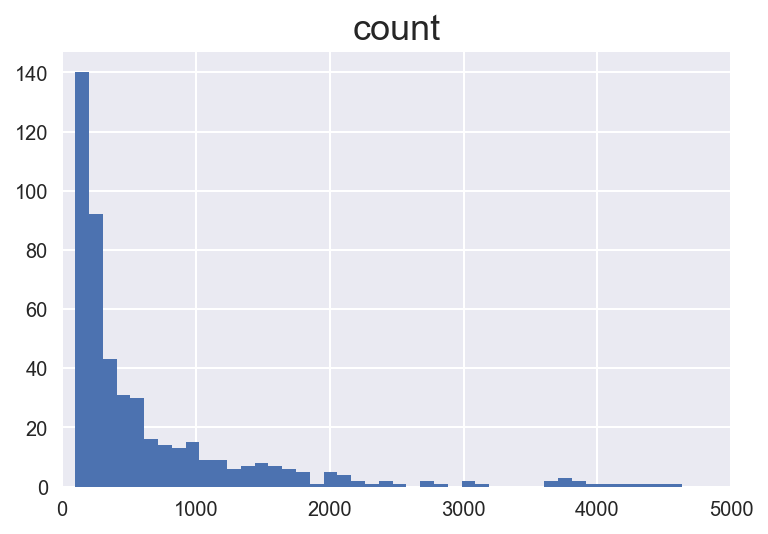

In [5]:
# Keep categories with at least 100 businesses
cat_count = cat_count[cat_count['count'] > 100]
cat_count.hist(bins=500)
_ = plt.xlim([0, 5000])

In [6]:
# All Yelp categories, downloaded from https://www.yelp.com/developers/documentation/v3/category_list
categories = json.loads(open('../data/categories.json').read())

id2cat = {
    x['alias']: x
    for x in categories
}

def cat_level(x, level=0):
    if len(x['parents']) == 0:
        return level + 1
    for parent in x['parents']:
        parent = id2cat[parent]
        return cat_level(parent, level + 1)
    
# The root categories
root_categories = [x['title'] for x in categories if len(x['parents']) == 0]
second_level_categories = [x['title'] for x in categories if cat_level(x) < 3]

FileNotFoundError: [Errno 2] No such file or directory: '../data/categories.json'

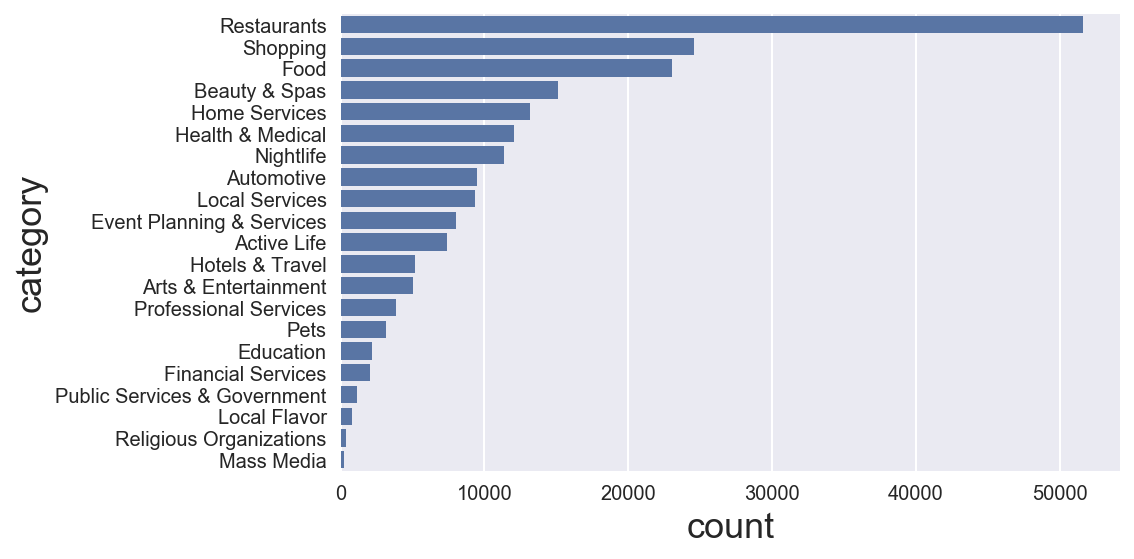

In [62]:
root_cat_count = cat_count[cat_count['category'].isin(root_categories)]

g = sns.factorplot(
    y='category',
    x='count',
    kind='bar',
    color='b',
    aspect=2,
    data=root_cat_count)

In [54]:
from sklearn.preprocessing import MultiLabelBinarizer

binarizer = MultiLabelBinarizer()
biz_cats_full = business_df['categories']

In [44]:
biz_cat_df = pd.DataFrame(
    data=biz_cats,
    columns=binarizer.classes_,
    index=business_df.index)
biz_cat_df.head()

,Active Life,Arts & Entertainment,Automotive,Beauty & Spas,Bicycles,Education,Event Planning & Services,Financial Services,Food,Health & Medical,...,Local Flavor,Local Services,Mass Media,Nightlife,Pets,Professional Services,Public Services & Government,Religious Organizations,Restaurants,Shopping
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


## Attributes

In [130]:
biz_attrs = json_normalize(business_df.to_dict('list'), ['attributes'])
business_df = business_df.drop(['attributes', 'categories'], axis=1)

In [102]:
# proportion of businesses with the attribute set
top_attrs = biz_attrs.isnull().agg('mean').sort_values()

In [106]:
pd.set_option('display.max_rows', 50)

print('Total number of attributes: {}'.format(len(top_attrs)))
display(top_attrs)

Total number of attributes: 39


BusinessAcceptsCreditCards    0.229113
RestaurantsPriceRange2        0.384859
BusinessParking               0.429012
BikeParking                   0.530768
GoodForKids                   0.627411
RestaurantsTakeOut            0.651121
OutdoorSeating                0.678816
RestaurantsGoodForGroups      0.683170
RestaurantsDelivery           0.701205
RestaurantsReservations       0.702992
RestaurantsAttire             0.713909
Alcohol                       0.717567
WheelchairAccessible          0.718952
HasTV                         0.720836
WiFi                          0.722745
GoodForMeal                   0.725790
Ambience                      0.726122
NoiseLevel                    0.740467
RestaurantsTableService       0.744885
ByAppointmentOnly             0.777942
Caters                        0.779538
DogsAllowed                   0.928409
BusinessAcceptsBitcoin        0.943335
AcceptsInsurance              0.945250
GoodForDancing                0.945524
HappyHour                

In [131]:
business_df['price_range'] = biz_attrs['RestaurantsPriceRange2']
business_df

,address,business_id,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state,price_range
0,691 Richmond Rd,YDf95gJZaq05wvo7hTQbbQ,Richmond Heights,"{'Monday': '10:00-21:00', 'Tuesday': '10:00-21...",1,41.541716,-81.493116,Richmond Town Square,,44143,17,2.0,OH,2.0
1,2824 Milton Rd,mLwM-h2YhXl2NCgdS84_Bw,Charlotte,"{'Monday': '10:00-22:00', 'Tuesday': '10:00-22...",0,35.236870,-80.741976,South Florida Style Chicken & Ribs,Eastland,28215,4,4.5,NC,2.0
2,337 Danforth Avenue,v2WhjAB3PIBA8J8VxG3wEg,Toronto,"{'Monday': '10:00-19:00', 'Tuesday': '10:00-19...",0,43.677126,-79.353285,The Tea Emporium,Riverdale,M4K 1N7,7,4.5,ON,2.0
3,"7702 E Doubletree Ranch Rd, Ste 300",CVtCbSB1zUcUWg-9TNGTuQ,Scottsdale,"{'Friday': '9:00-17:00', 'Tuesday': '9:00-17:0...",1,33.565082,-111.916400,TRUmatch,,85258,3,3.0,AZ,NaN
4,4719 N 20Th St,duHFBe87uNSXImQmvBh87Q,Phoenix,{},0,33.505928,-112.038847,Blimpie,,85016,10,4.5,AZ,1.0
5,2017 E Camelback Rd,uUEMrhJiL1a1pCA_I1SU7Q,Phoenix,"{'Monday': '10:00-20:00', 'Tuesday': '10:00-20...",0,33.508068,-112.037552,Baxter's Cigars,,85016,35,5.0,AZ,2.0
6,"4425 N 24th St, Ste 125",2eJEUJIP54tex7T9YOcLSw,Phoenix,"{'Friday': '9:00-12:00', 'Tuesday': '14:00-19:...",1,33.502848,-112.012696,Back-Health Chiropractic,,85016,19,5.0,AZ,NaN
7,5770 Butler St,fEylCY3UEH8YJ0Xa7lu6lA,Pittsburgh,"{'Monday': '8:00-17:00', 'Tuesday': '8:00-17:0...",1,40.485939,-79.943727,Auto Bathouse,Lawrenceville,15201,16,2.5,PA,NaN
8,3220 Washington Rd,kFtuYklkAIlmYw8RZAieGw,McMurray,"{'Monday': '10:00-18:00', 'Tuesday': '10:00-18...",1,40.290498,-80.110021,JAB Jewelry Designs,,15317,7,5.0,PA,2.0
9,"1425 S Higley Rd, Ste 103",NqiQdFa93wzUJGo29NbTPQ,Gilbert,"{'Friday': '7:30-11:00', 'Tuesday': '7:30-17:0...",1,33.324539,-111.720449,Neighborhood Vision Center,,85296,8,5.0,AZ,NaN
